# Black-Scholes options pricing

The [Black-Scholes formula](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model#Black%E2%80%93Scholes_formula) calculates prices for (European) put and call stock options. The inputs to this formula are:

* $S$ is the current option price
* $X$ is the strike price
* $T$ is the time to expiration
* $r$ is the continuously compounded risk free interest rate
* $v$ is the implied volatility for the underlying stock

<details>
<summary>License</summary>
<pre>

Copyright 2023 NVIDIA Corporation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
</pre>
</details>

To get started, `import cunumeric as np` (just the same way we would import `numpy`)

In [1]:
import cunumeric as np  # instead of numpy

The Cumulative Normal Distribution (CND) is defined as 
$$
\frac{1}{2\pi}\int_{-\infty}^{x} e^{-t^2/2}\; dt = \frac12\big[1 + \mathtt{erf}\big(\frac{x}{\sqrt{2}}\big)\big]
$$

In order to compute this efficiently, an expansion approximation (from John C. Hull (1997) “Options, Futures, and Other Derivatives”) is used.

In [2]:
def CND(d):
    # The expansion coefficients for erf are derived from Abramowitz and Stegun, eq 7.1.26 
    # https://www.cs.bham.ac.uk/~aps/research/projects/as/resources/AandS-a4-v1-2.pdf
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438  # 1 / sqrt(2*pi)

    K = 1.0 / (1.0 + 0.2316419 * np.abs(d))

    cnd = RSQRT2PI * np.exp(-0.5*d*d) * (K*(A1 + K*(A2 + K*(A3 + K*(A4 + K*A5)))))

    return np.where(d > 0, 1.0 - cnd, cnd)

Now that we have a method to compute the CND, we can implement the Black-Scholes formula below

In [3]:
def black_scholes(S, X, T, r, v):
    sqrt_T = np.sqrt(T)
    
    d1 = np.log(S / X) + (r + 0.5 * v * v) * T / (v * sqrt_T)
    cnd_d1 = CND(d1)

    d2 = d1 - v * sqrt_T
    cnd_d2 = CND(d2)
    
    exp_rT = np.exp(-r * T)
    
    call_result = S * cnd_d1 - X * exp_rT * cnd_d2
    put_result = X * exp_rT * (1.0 - cnd_d2) - S * (1.0 - cnd_d1)

    return call_result, put_result

Let's use the `black_scholes` function above to price one million put and call options, keeping everying fixed except the current option price $S$. 

In [4]:
# Because of Legate's deferred execution model, legate.timing should be used instead
# of standard Python datetime utilities. Python datetime.now would return the time
# a task is *scheduled*, not necessarily the time a task finishes executing.
from legate.timing import time

In [5]:
N = 1000000                 # number of options to price
S = np.linspace(5, 100, N)  # current option price
X = 100                     # strike price
T = 10                      # time to expiration
r = 0.05                    # continuously compounded risk free interest rate
v = 0.3                     # implied volatility for the underlying stock

start = time()
call, put = black_scholes(S, X, T, r, v)
stop = time()

print(f"Elapsed Time: {(stop - start) / 1000.0} ms")

/home/bryan/work/legate.core/legate/core/context.py:280: RuntimeWarning: cuNumeric has not implemented numpy.result_type and is falling back to canonical numpy. You may notice significantly decreased performance for this function call.
  result = func(*args, **kwargs)
Elapsed Time: 45.659 ms


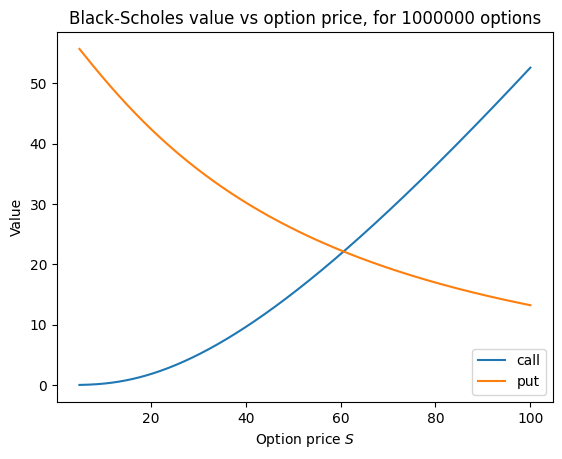

In [6]:
import matplotlib.pyplot as plt

plt.plot(S, call, label="call")
plt.plot(S, put, label="put")
plt.title(f"Black-Scholes value vs option price, for {N} options")
plt.xlabel("Option price $S$")
plt.ylabel("Value")
plt.legend();